# Deel I. Machine learning

## Hoofdstuk 1. Het perceptron

1. [Inleiding](#Inleiding)
2. [Het perceptron](#Het_perceptron)
3. [Lineaire regressie](#Lineaire_regressie)

### <a id='Inleiding'>Inleiding</a>

Dit is het Jupyter Notebook behorende bij hoofdstuk 1 van het vak *Advanced Datamining* (BFVH4DMN2). Op BlackBoard tref je eveneens een module `data.py` aan die diverse functies bevat die helpen bij het genereren en het visualiseren van de gebruikte datasets. Creeër daarnaast een bestand `model.py` in een code-editor naar keuze en sla al deze bestanden gezamenlijk op in één werkmap. 

<div class="alert alert-info">
    
**Opmerking:**
    
Op BlackBoard tref je ook een `*.html` versie van dit notebook aan met daarin de evaluaties van alle onderstaande code. Gebruik deze zonodig als voorbeeld om te zien welke uitvoer zoal gewenst is.

</div>

We beginnen met het importeren van de functies in de `data` module, samen met de nu nog lege `model` module die je zelf gaat schrijven. Verder laden we alvast enkele ondersteunende functies uit de modules `sklearn` en `pandas` die we later zullen gebruiken, en voeren we wat initialisatie-code uit. Plaats de cursor in de cel hieronder en druk op Ctrl+Enter (of Shift+Enter om meteen naar de volgende cel te gaan).

<div class="alert alert-info">
    
**Opmerking:**
    
Als het label in de linkermarge verandert van `In [ ]:` via `In [*]:` naar `In [1]:` is de code succesvol uitgevoerd en werkt dit notebook naar behoren.

</div>

In [104]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from sys import version
print(f'Using python version {version.split(" ")[0]}')

from pandas import DataFrame, __version__
print(f'Using pandas version {__version__}')

from sklearn import linear_model, __version__
print(f'Using sklearn version {__version__}')

import model, data

[autoreload of model failed: Traceback (most recent call last):
  File "c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 459, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\lukas\OneDrive\Documenten\School\H

Using python version 3.11.1
Using pandas version 2.2.0
Using sklearn version 1.4.0


<div class="alert alert-info">
    
**Opmerking:**
    
Als `pandas` of `sklearn` niet geinstalleerd is op je systeem, voer dan `pip3 install pandas sklearn` uit in een terminal en herstart de python kernel via de menu-optie `Kernel` > `Restart` van dit notebook.

</div>

Laten we eerst eens beter kijken naar de dataset die we in dit werkcollege gaan gebruiken. De functie `data.linear()` produceert een verzameling willekeurige instances met numerieke attributen. Er zijn onder andere parameters om het aantal instances en het aantal attributen te bepalen. Al deze parameters hebben geschikte default waarden. Een verplichte string parameter geeft aan of de dataset discrete uitkomsten dient te hebben t.b.v. classificatie (`outcome='nominal'`) of continue uitkomsten t.b.v. regressie (`outcome='numeric'`).

In [105]:
help(data.linear)

Help on function linear in module data:

linear(outcome, *, num=100, dim=2, noise=0.0, seed=None)
    Generate a linear dataset with attributes and outcomes.
    
    Arguments:
    outcome  -- string indicating 'nominal' or 'numeric' outcomes
    
    Keyword options:
    num      -- number of instances (default 100)
    dim      -- dimensionality of the attributes (default 2)
    noise    -- the amount of noise to add (default 0.0)
    seed     -- a seed to initialise the random numbers (default random)
    
    Return values:
    xs       -- values of the attributes
    ys       -- values of the outcomes



De functie retourneert een geneste lijst met vectoren die de attributen van de instances bevat en een enkelvoudige lijst met klasselabels danwel getalwaarden die de bijbehorende uitkomsten bevat. De nominale data zijn lineair separabel; de continue data volgen een exacte lineaire relatie. De algoritmen die we in dit werkcollege implementeren zouden hierdoor in principe in staat behoren te zijn deze data *perfect* te modelleren.

### <a id='Het_perceptron'>Het perceptron</a>

Laten we beginnen met een dataset met twee attributen $(x_1, x_2)$ en met nominale klasselabels $y$ waarop we classificatie kunnen toepassen d.m.v. het perceptron. De eerste vijf instances worden hieronder weergegeven in tabelvorm.

In [106]:
xs, ys = data.linear('nominal')
DataFrame(xs, columns=['x1', 'x2']).assign(y=ys).head()

,x1,x2,y
0,1.155816,-1.190220,-1.0
1,1.668562,-2.624815,-1.0
2,-0.647402,1.881216,1.0
3,0.858429,0.966863,1.0
4,1.113954,-0.376300,1.0


Verken zelf nader de structuur van de `xs` en `ys` variabelen: wat voor type variabelen zijn het, hoe lang zijn de lijsten, en zo verder.

De functie `data.scatter()` geeft de instances van beide klassen weer middels een kleurcode (rood voor de klasse $y=-1$ en blauw voor de klasse $y=+1$).

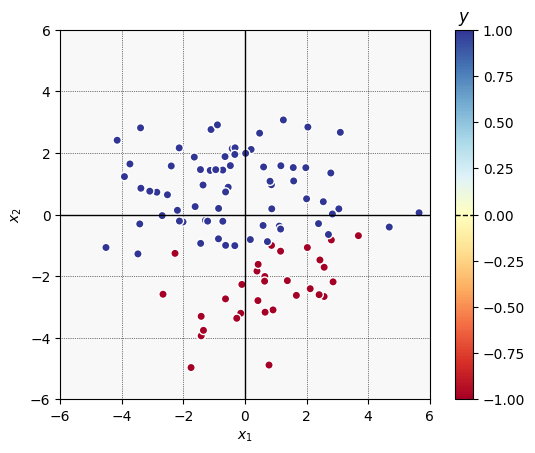

In [107]:
data.scatter(xs, ys)

Definieer nu een `Perceptron()` class in het bestand `model.py` met aanvankelijk alleen de onderstaande `__repr__()` methode die een textuele representatie geeft van het object:

```python
class Perceptron():

    def __repr__(self):
		text = f'Perceptron(dim={self.dim})'
		return text
```

<div class="alert alert-info">
    
**Opmerking:**
    
Vergeet niet om tijdens het uitwerken van deze oefening je aanpassingen in de editor telkens op te slaan voordat je de code in dit notebook uitvoert.
    
</div>
 
We beginnen met het implementeren van de initialisatie-methode `__init__()`. Deze krijgt één verplichte parameter `dim` die aangeeft hoeveel attributen de te classificeren instances zullen hebben. Verder dienen er twee instance-variabelen te worden geïnitialiseerd: `bias` met de bias $b$ en `weights` met de gewichten $\boldsymbol{w}$; de methode dient deze zelf van geschikte beginwaarden te voorzien.

Het resultaat is iets als:

```python
    def __init__(self, dim):
        self.dim = ...
        self.bias = ...
        self.weights = ...
```

<div class="alert alert-info">

**Opmerking:**
    
Voorzie je eigen code waar nodig van documentatie en commentaren, evenals desgewenst assertions en foutafhandeling. In de voorbeelden in deze notebooks worden deze niet getoond omwille van bondigheid, maar het gebruik hiervan wordt desalniettemin aangeraden.

</div>

Als het goed is kun je nu zonder foutmeldingen een nieuw eigen `Perceptron()` object instantiëren en weergeven met de volgende code.

In [108]:
my_perceptron = model.Perceptron(dim=2)
print(my_perceptron)
print(f'- bias = {my_perceptron.bias}')
print(f'- weights = {my_perceptron.weights}')

Perceptron(dim=2)
- bias = 0
- weights = [0, 0]


De volgende stap is om de code te schrijven die voor een gegeven instance een voorspelling kan doen van het juiste klasselabel op grond van het model van het perceptron:

$$
\hat{y}=\text{sgn}\left(b+\sum_{i}w_{i}\cdot x_{i}\right)
$$

Creeër een methode `predict(self, xs)` met een parameter `xs` die de attributen van een lijst instances ontvangt. Deze methode dient een lijst waarden te retourneren die overeenkomen met de uitkomsten van de bovenstaande formule. De invoer van deze functie is dus een geneste lijst van lijsten; de uitvoer is een enkelvoudige lijst.

Als je deze code correct hebt geïmplementeerd kunnen we het model vragen om een voorspelling te doen omtrent de labels van de beschikbare data. Omdat het perceptron nog niet getraind is is de voorspelling $\hat{y}$ overal gelijk aan nul. Als je hieronder geen foutmeldingen krijgt dan functioneert je predictie-methode vooralsnog.

In [109]:
my_perceptron = model.Perceptron(dim=2)
#print(xs) # index 0 is x1 en index 1 is x2
yhats : list = my_perceptron.predict(xs) # ys is short for yhats
DataFrame(xs, columns=['x1', 'x2']).assign(y=ys, ŷ=yhats).head()

,x1,x2,y,ŷ
0,1.155816,-1.190220,-1.0,0.0
1,1.668562,-2.624815,-1.0,0.0
2,-0.647402,1.881216,1.0,0.0
3,0.858429,0.966863,1.0,0.0
4,1.113954,-0.376300,1.0,0.0


Vervolgens gaan we het perceptron trainen op grond van instances met gegeven attributen en klasselabels. Pas hiervoor met de aangeleverde instances één voor één de update-regel toe:

$$
\left\{ \begin{array}{c}
b\leftarrow b-\left(\hat{y}-y\right)\\
w_{i}\leftarrow w_{i}-\left(\hat{y}-y\right)x_{i}
\end{array}\right.
$$

Voeg een methode `partial_fit()` toe aan je perceptron met parameters die de attributen en klasselabels van een aantal trainingsinstances ontvangt. Het resultaat is iets als:

```python
    def partial_fit(self, xs, ys):
        for x, y in zip(xs, ys):
            ...   # Update hier het perceptron met één instance {x, y}
```

De methode dient elke instance één maal te gebruiken om een update uit te voeren; er wordt dus één epoch getraind met de gegeven data. Deze functie hoeft niets te retourneren.

Als je deze code correct hebt geïmplementeerd zou je hieronder een gekleurde achtergrond moeten zien die weergeeft hoe het perceptron de verschillende waarden van de attributen zou classificeren nadat het éénmaal getraind is op de eerste vijf instances uit de dataset.

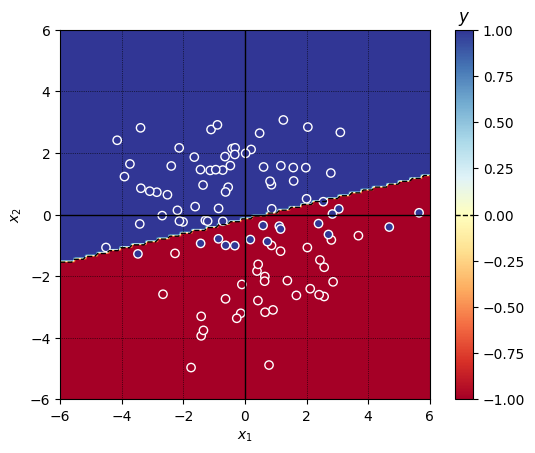

Perceptron(dim=2)
- bias = 1.0
- weights = [-1.499396765043247, 6.286814026589078]


In [110]:
my_perceptron = model.Perceptron(dim=2)
my_perceptron.partial_fit(xs[:5], ys[:5])
data.scatter(xs, ys, model=my_perceptron)
print(my_perceptron)
print(f'- bias = {my_perceptron.bias}')
print(f'- weights = {my_perceptron.weights}')

Hoogstwaarschijnlijk zal er nog geen correcte grenslijn gevonden worden, maar het perceptron doet wel al een aantal juiste voorspellingen en je zou moeten kunnen zien dat de bias en gewichten zijn bijgewerkt.

Voeg tenslotte een methode `fit(self, xs, ys, *, epochs=0)` toe die meerdere epochs uitvoert, zoals opgegeven door de gebruiker. Maak hierbij gebruik van de eerdere `partial_fit()` functie om telkens één hele epoch te trainen. Zorg dat het perceptron automatisch stopt met het draaien van verdere epochs als er in de vorige epoch geen veranderingen in het model meer zijn aangebracht. Als de gebruiker om nul epochs verzoekt (of geen waarde meegeeft waardoor de default waarde `epochs=0` geldt), laat dan het algoritme zoveel epochs draaien als maar nodig zijn om te convergeren.

[autoreload of model failed: Traceback (most recent call last):
  File "c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\extensions\autoreload.py", line 459, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\lukas\AppData\Local\Programs\Python\Python311\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\lukas\OneDrive\Documenten\School\H

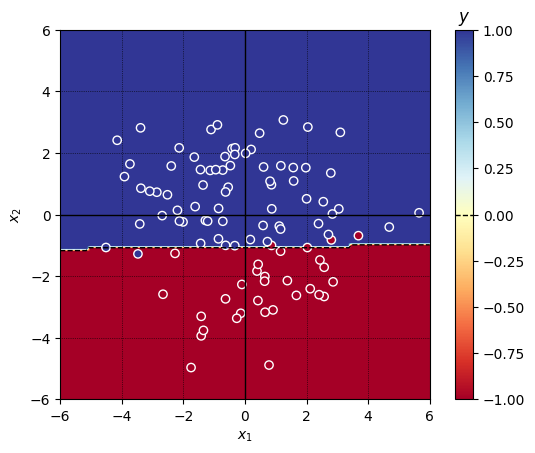

Perceptron(dim=2)
- bias = 164.0
- weights = [-1.6823384541641415, 153.38500915927392]


In [112]:

# my_perceptron.fit(xs,ys, epochs=6)
my_perceptron = model.Perceptron(dim=2)
my_perceptron.fit(xs, ys)
data.scatter(xs, ys, model=my_perceptron)
print(my_perceptron)
print(f'- bias = {my_perceptron.bias}')
print(f'- weights = {my_perceptron.weights}')

Rosenblatt heeft bewezen dat het perceptron algoritme gegarandeerd in een eindig aantal stappen convergeert naar een oplossing die alle instances juist classificeert als de data lineair separabel zijn. Dat is hier het geval. Als je dit juist implementeert zou de bovenstaande code daarom een lijn moeten vinden die de beide klassen perfect van elkaar weet te scheiden.

Hieronder worden de eerste vijf instances in een tabel getoond; ga na dat de voorspelling $\hat{y}$ telkens precies gelijk is aan het echte klasselabel $y$.

In [113]:
yhats = my_perceptron.predict(xs)
DataFrame(xs, columns=['x1', 'x2']).assign(y=ys, ŷ=yhats).head()

,x1,x2,y,ŷ
0,1.155816,-1.190220,-1.0,-1.0
1,1.668562,-2.624815,-1.0,-1.0
2,-0.647402,1.881216,1.0,1.0
3,0.858429,0.966863,1.0,1.0
4,1.113954,-0.376300,1.0,1.0


<div class="alert alert-success">
    
**Gefeliciteerd!**
    
Je hebt nu zelf een algoritme geïmplementeerd dat een lineair separabele verzameling trainingsdata perfect kan leren onderscheiden.

</div>

Ter vergelijking tonen we hieronder het perceptron zoals dit in de machine-learning module [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) reeds beschikbaar is. De syntax van deze class is zeer vergelijkbaar met de onze, hoewel de bias en coefficienten beschikbaar zijn in de `intercept_` en `coef_` variabelen, en een parameter `max_iter` het gewenste (maximum) aantal epochs aangeeft.

Ziet de oplossing er hetzelfde uit als voor je eigen model? Ga na dat de waarden van de bias en de gewichten niet van dezelfde grootten zijn. Begrijp je hoe dit toch ogenschijnlijk hetzelfde model kan opleveren?

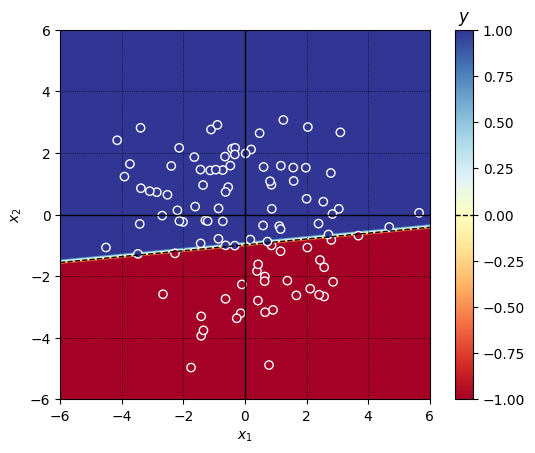

Perceptron()
- bias = 11.0
- weights = [-1.06269021 11.16343023]


In [114]:
skl_perceptron = linear_model.Perceptron(max_iter=1000)
skl_perceptron.fit(xs, ys)
data.scatter(xs, ys, model=skl_perceptron)
print(skl_perceptron)
print(f'- bias = {skl_perceptron.intercept_[0]}')
print(f'- weights = {skl_perceptron.coef_[0]}')

### <a id='Lineaire_regressie'>Lineaire regressie</a>

Vervolgens doen we hetzelfde met instances die een getalwaarde als te voorspellen uitkomst hebben. Eerst maar weer eens een kijkje nemen naar de data. De uitkomsten $y$ zijn nu numeriek, dat wil zeggen kommagetallen.

In [88]:
xs, ys = data.linear('numeric')
DataFrame(xs, columns=['x1', 'x2']).assign(y=ys).head()

,x1,x2,y
0,1.834113,-1.359454,-3.281625
1,-0.831433,-2.333511,-1.803361
2,1.635497,-2.851767,-4.055946
3,-1.816865,0.900728,0.982354
4,3.843701,-0.531683,-4.337909


De instances worden nu gekleurd langs het hele bereik van de kleurschaal. De ligging van de verschillende kleuren in het scatterplot vormt een zichtbare geleidelijke overgang van rood via geel naar blauw.

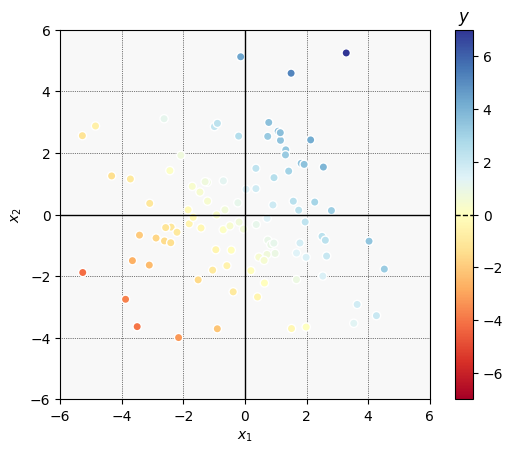

In [85]:
data.scatter(xs, ys)

Kopieer de code van het perceptron om een nieuwe class `LinearRegression()` toe te voegen aan hetzelfde bestand `model.py` en pas de initialisatie-, representatie- en predictie-methoden aan. Het model voor lineaire regressie luidt:

$$
\hat{y}=b+\sum_{i}w_{i}\cdot x_{i}
$$

De methode `predict(self, xs)` dient in dit geval een lijst met getalwaarden te retourneren i.p.v. een lijst met klasselabels.

Een ongetraind model zou wederom uitkomsten gelijk aan nul moeten voorspellen. Controleer dat je geen foutmeldingen krijgt.

In [89]:
my_linearregression = model.LinearRegression(dim=2)
yhats = my_linearregression.predict(xs)
DataFrame(xs, columns=['x1', 'x2']).assign(y=ys, ŷ=yhats).head()

[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0
[0, 0]
0
0

,x1,x2,y,ŷ
0,1.834113,-1.359454,-3.281625,0.0
1,-0.831433,-2.333511,-1.803361,0.0
2,1.635497,-2.851767,-4.055946,0.0
3,-1.816865,0.900728,0.982354,0.0
4,3.843701,-0.531683,-4.337909,0.0


Vervolgens gaan we het lineaire regressiemodel trainen, eerst weer op grond van de eerste vijf instances met de update-regel:

$$
\left\{ \begin{array}{c}
b\leftarrow b-\alpha\left(\hat{y}-y\right)\\
w_{i}\leftarrow w_{i}-\alpha\left(\hat{y}-y\right)x_{i}
\end{array}\right.
$$

De methode `partial_fit(self, xs, ys, *, alpha=...)` krijgt nu een extra parameter, de learning rate $\alpha$. Geef deze een geschikte default waarde.

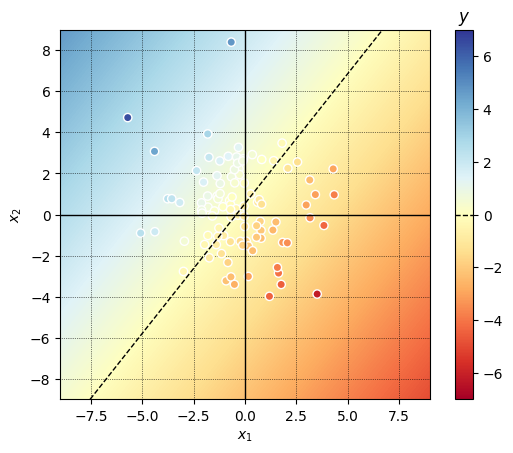

Perceptron(dim=2)
- bias = -0.12496486942043136
- weights = [-0.2961141714404696, 0.2342722259193341]


In [100]:
my_linearregression = model.LinearRegression(dim=2)
my_linearregression.partial_fit(xs[:5], ys[:5])
data.scatter(xs, ys, model=my_linearregression)
print(my_linearregression)
print(f'- bias = {my_linearregression.bias}')
print(f'- weights = {my_linearregression.weights}')

Na het trainen met enkele instances zou er al een zwakke gradiënt in de achtergrond zichtbaar kunnen worden. De diagonale stippellijn geeft hierboven aan waar de voorspelling $\hat{y}=0$; deze scheidt dus de instances met een voorspelde positieve uitkomst van die met een voorspelde negatieve uitkomst.

Voeg nu tenslotte weer de methode `fit(self, xs, ys, *, alpha=..., epochs=...)` toe die training toepast op een gegeven aantal hele epochs. Pas de default waarde voor de learning rate weer aan, in overeenstemming met de functie `partial_fit()`. In tegenstelling tot bij het perceptron kan het aantal epochs nu niet default op nul worden gesteld, met als betekenis dat het algoritme door dient te itereren tot alle instances juist geclassificeerd zijn. Immers, het lineaire regressie model convergeert meestal niet in een eindig aantal stappen naar een exacte uitkomst. Wel wordt er bij een juiste keuze van $\alpha$ geleidelijk een steeds betere benadering gevonden. Vandaar dat we hier standaard een redelijk groot aantal epochs willen uitvoeren. Kies wederom zelf een geschikte default waarde.

Draai de code hieronder. Slaagt je model erin om te convergeren naar een uitkomst die de echte getalwaarden van de instances ogenschijnlijk goed voorspelt? Hoe kun je dit zien?

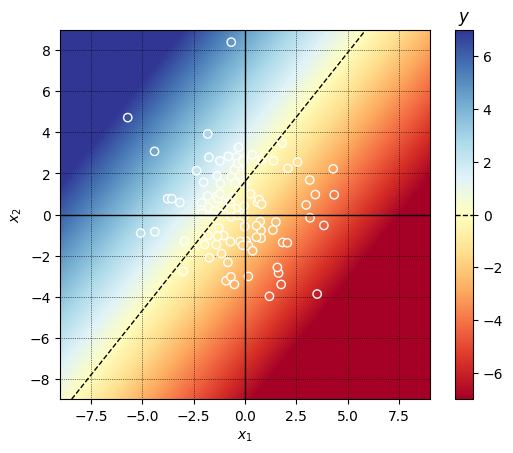

Perceptron(dim=2)
- bias = -0.9999441672153218
- weights = [-0.7822296482768843, 0.6229786998284199]


In [101]:
my_linearregression = model.LinearRegression(dim=2)
my_linearregression.fit(xs, ys)
data.scatter(xs, ys, model=my_linearregression)
print(my_linearregression)
print(f'- bias = {my_linearregression.bias}')
print(f'- weights = {my_linearregression.weights}')

Controleer hieronder dat de voorspellingen inderdaad goed overeen komen met de gewenste waarden.

In [102]:
yhats = my_linearregression.predict(xs)
DataFrame(xs, columns=['x1', 'x2']).assign(y=ys, ŷ=yhats).head()

,x1,x2,y,ŷ
0,1.834113,-1.359454,-3.281625,-3.281553
1,-0.831433,-2.333511,-1.803361,-1.803300
2,1.635497,-2.851767,-4.055946,-4.055869
3,-1.816865,0.900728,0.982354,0.982395
4,3.843701,-0.531683,-4.337909,-4.337829


<div class="alert alert-success">
    
**Gefeliciteerd!**
    
Je hebt nu ook een algoritme geïmplementeerd dat lineaire regressie kan uitvoeren.

</div>

Ter vergelijking tonen we hieronder ook weer het lineaire regressiemodel uit de machine-learning module [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Bekijk de syntax van deze functie. De bias en coefficienten zijn opnieuw toegankelijk via de `intercept_` en `coef_` variabelen.

Ziet de oplossing er dit keer hetzelfde uit als voor je eigen model? Zijn de waarden van de bias en de gewichten nu wel van vergelijkbare grootten?

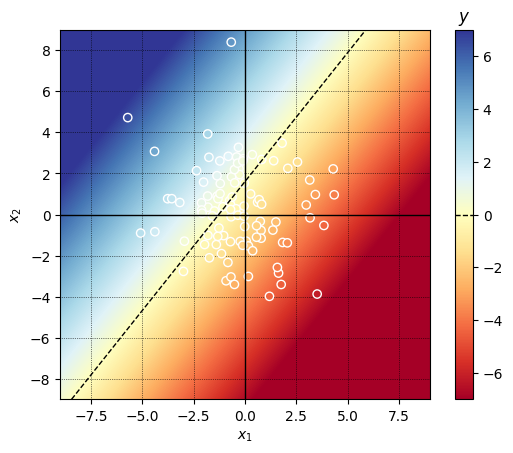

LinearRegression()
- bias = -1.0
- weights = [-0.7822355   0.62298284]


In [103]:
skl_linearregression = linear_model.LinearRegression()
skl_linearregression.fit(xs, ys)
data.scatter(xs, ys, model=skl_linearregression)
print(skl_linearregression)
print(f'- bias = {skl_linearregression.intercept_}')
print(f'- weights = {skl_linearregression.coef_}')

***

<small>&copy; 2024, Dave R.M. Langers, [d.r.m.langers@pl.hanze.nl](mailto:d.r.m.langers@pl.hanze.nl)</small>